# Analyzing Reservoir's Transient Responses

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
from preprocess_digits import RECORDINGS_DIR, save_data, load_data

In [2]:
plt.rc("font", family="Arial")
plt.rc("mathtext", fontset="cm")

Pmax = 0.476620 mW
Pmin = 0.000966 mW
M = 0.996 (ext. ratio = 26.932825 dB)
Vpi = 5.365770 V
M = 0.996
phi = 0.69pi


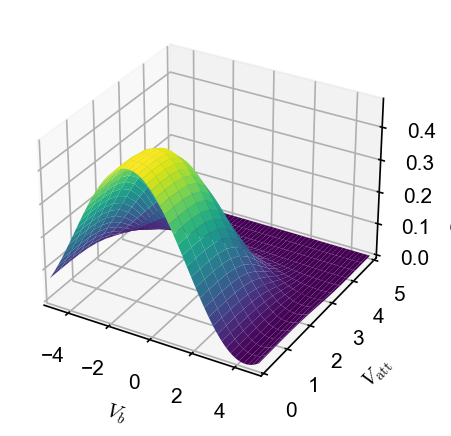

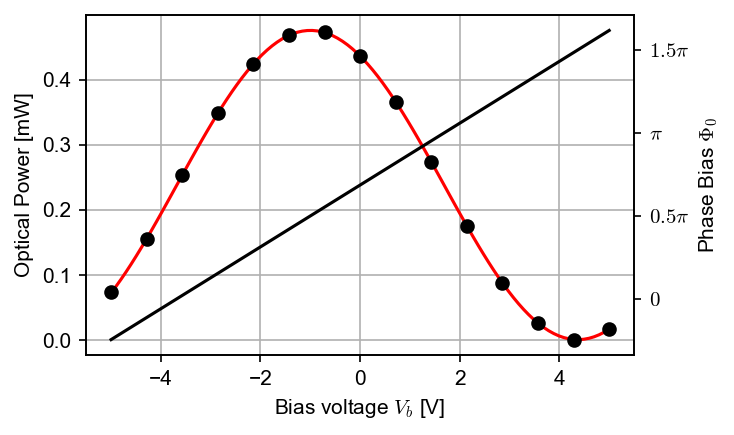

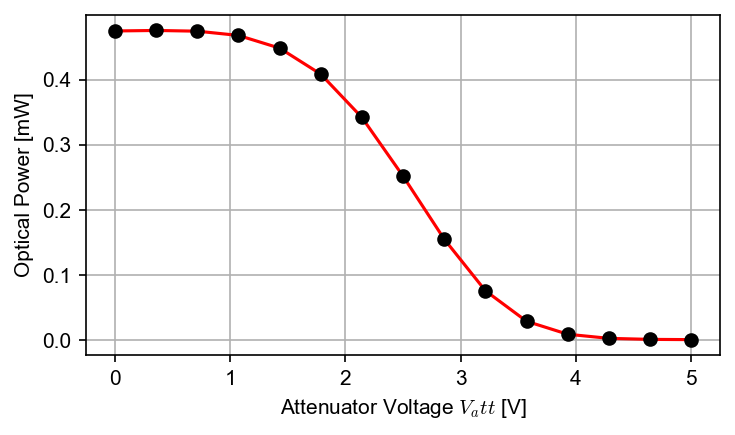

In [3]:
%run show_calibration.py

In [4]:
history = np.load("data/history.npy")
t = history["Time (s)"]
ch1 = history["Probe A (V)"]
ch2 = history["Probe B (V)"]

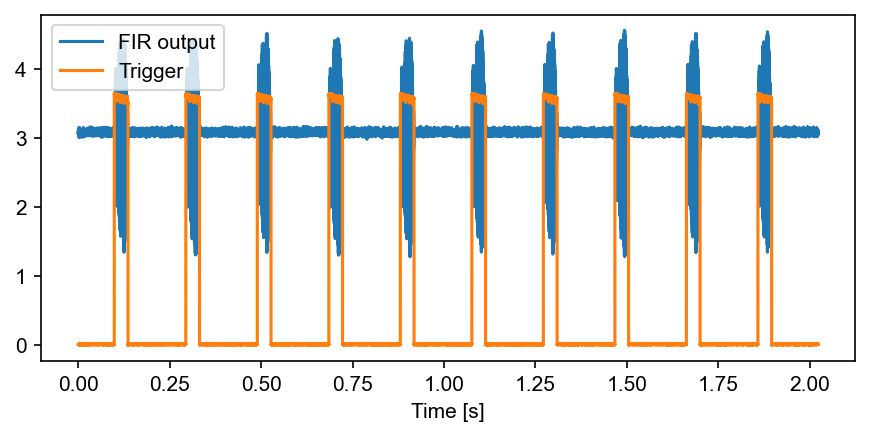

In [5]:
plt.figure(figsize=(7, 3))
plt.plot(t[::], ch1[::], label="FIR output")
plt.plot(t[::], ch2[::], label="Trigger")
plt.xlabel("Time [s]")
plt.legend(loc='upper left');

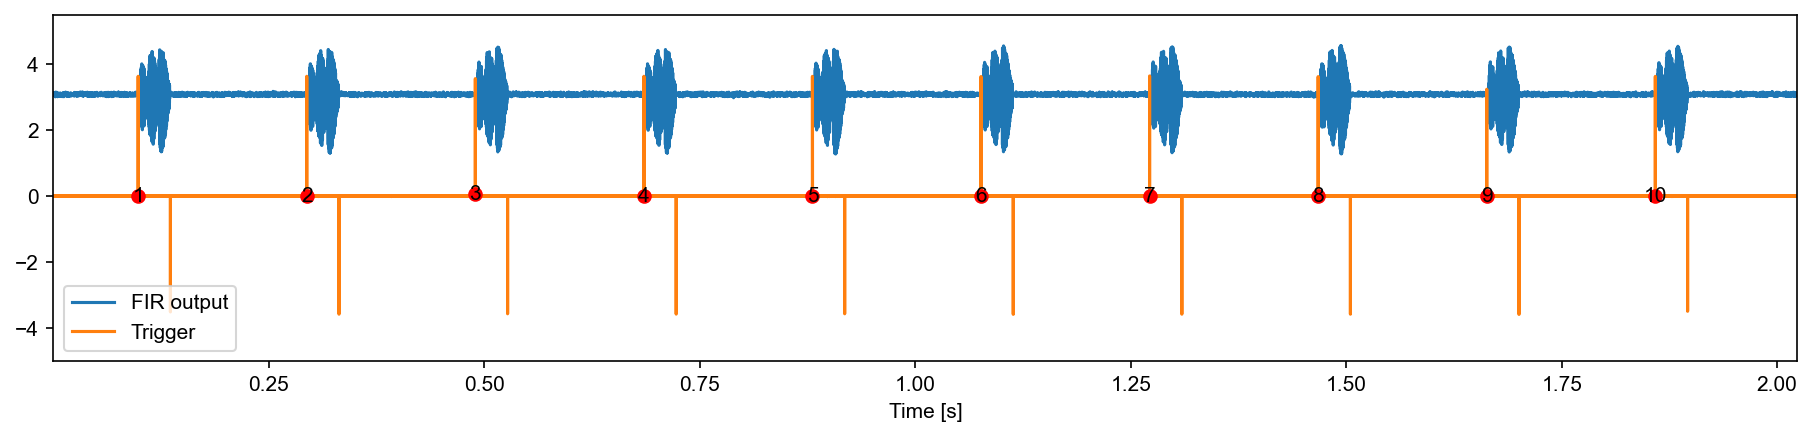

In [6]:
rate = 5e5
holdoff = 0.005
distance = int(holdoff * rate)

import scipy.signal

diff_ch2 = np.r_[ch2[1:] - ch2[:-1], 0]
peaks, *info = scipy.signal.find_peaks(diff_ch2, height=(1, 4), distance=distance)

plt.figure(figsize=(15, 3))
idx = np.logical_and(t > 0., t < 4)

plt.plot(t[idx], ch1[idx], label="FIR output")
plt.plot(t[idx], diff_ch2[idx], label="Trigger")
line, = plt.plot(t[peaks], ch2[peaks], "ro")
pk_x, pk_y = line.get_data()
for i in range((len(pk_x))):
    plt.annotate(str(i + 1), (pk_x[i], pk_y[i]), ha='center', va='center')
plt.xlim(t[idx][0], t[idx][-1])
plt.ylim(-5, 5.5)
plt.xlabel("Time [s]")
plt.legend(loc="lower left");

In [7]:
import pickle
from reservoir import ExperimentalReservoir

with open("data/recognize_digits.pickle", "rb") as f:
    dump = pickle.load(f)
    
# with open("data/transients.pickle", 'rb') as f:
#     transients = pickle.load(f)

rc = ExperimentalReservoir(**dump["hypers"])

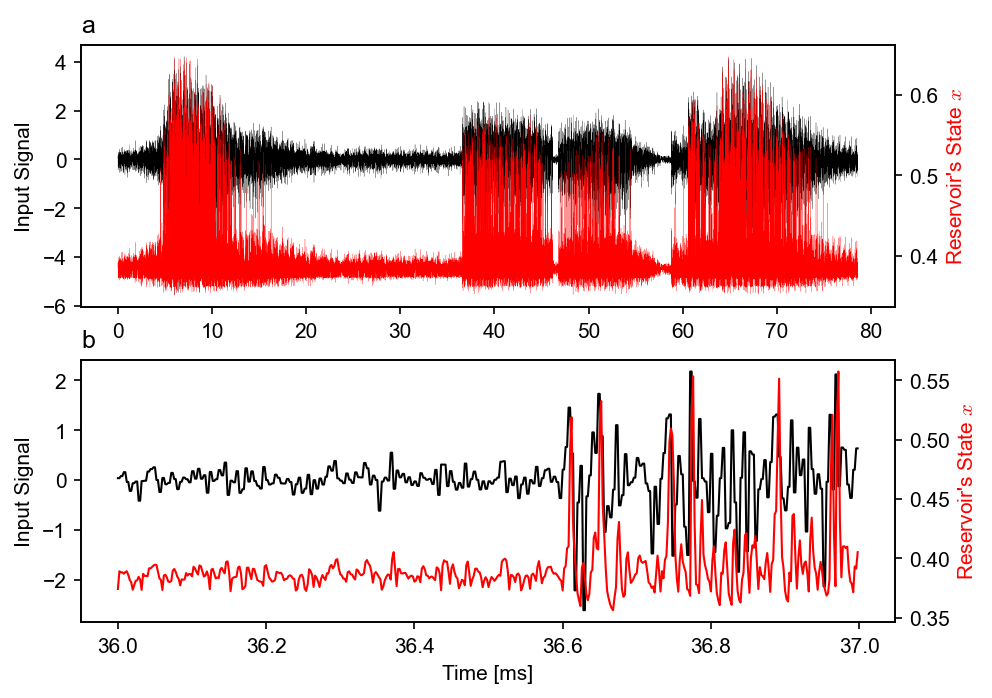

In [20]:
i = 0
t = dump["transients_train"]["time"][i]
x = dump["x_train"][i]
tran = dump["transients_train"]["ch1"][i]
s = dump["transients_train"]["state"][i]


fig = plt.figure(figsize=(7, 5))
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 1, fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
u_in = rc.multiplex(dump["Win"].dot(x.T)) 
ax1.plot(t * 1e3, u_in / Vpi, linewidth=0.1, color="k", label="Input")
ax1t = ax1.twinx()
ax1t.plot(t * 1e3, tran / Vpi, linewidth=0.1, color="r", label="Reservoir State")
# ax1.set_xlabel("Time [ms]")
ax1.set_title("a", loc='left')
ax1.set_ylabel("Input Signal")
ax1t.set_ylabel("Reservoir's State $x$", color="r")

idx = np.logical_and(t >= 36e-3, t < 37e-3)
ax2.set_title("b", loc='left')
ax2.plot(t[idx] * 1e3, u_in[idx] / Vpi, linewidth=1, color="k", label='Input')
ax2t = ax2.twinx()
ax2t.plot(t[idx] * 1e3, tran[idx] / Vpi, linewidth=1, color="r", label="Reservoir State")
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Input Signal")
ax2t.set_ylabel("Reservoir's State $x$", color="r")
# ax2.legend(loc="lower right")
fig.savefig("../../Figures/transients.pdf")

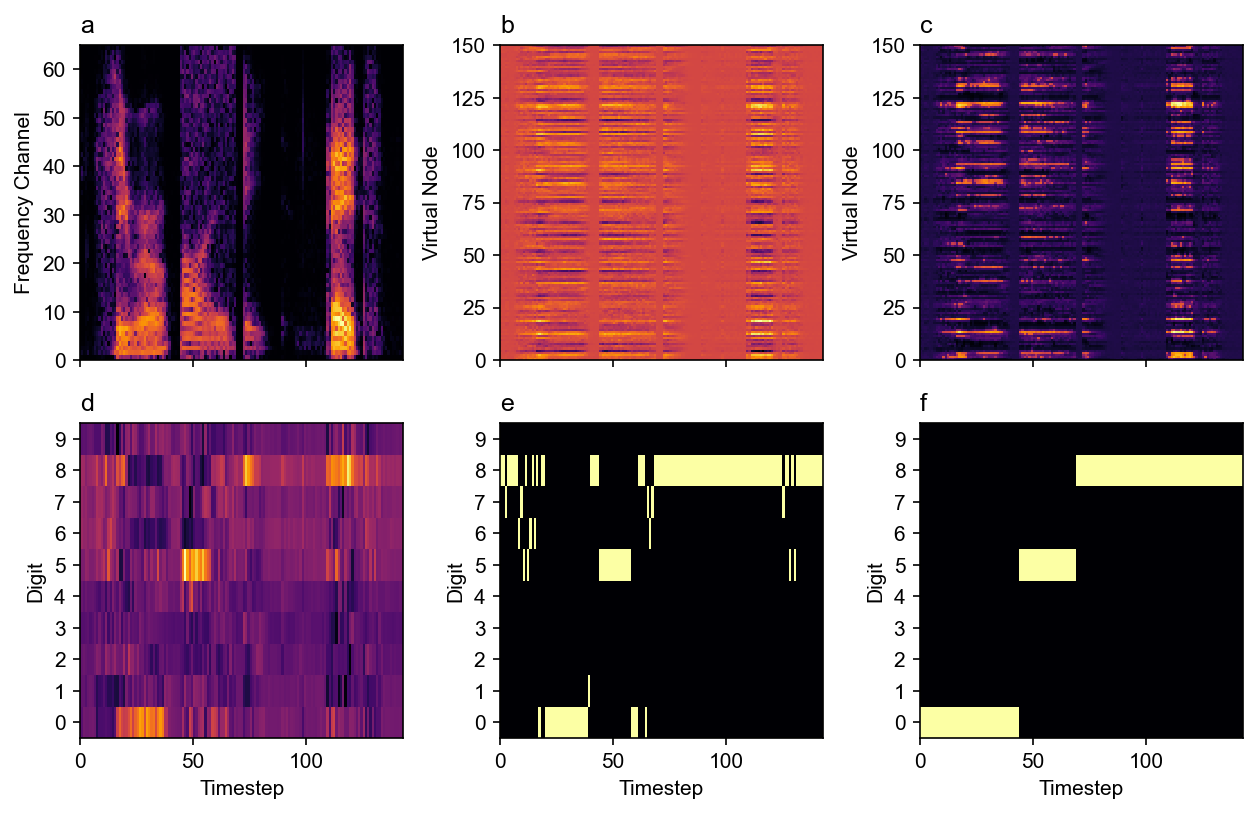

In [13]:
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots(2, 3, sharex=True, gridspec_kw=dict(wspace=0.3))
ax0, ax1, ax2, ax3, ax4, ax5 = ax.flat
from matplotlib.gridspec import GridSpec
# gs = GridSpec(2, 2, fig, hspace=0.1)
# tran = np.log(1 + tran)

# ax0 = fig.add_subplot(gs[0, 0])
# ax1 = fig.add_subplot(gs[1, 0])
# ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, 1])

i = 3
ds = "train"

s = dump["transients_" + ds]["state"][i]
X = dump["x_" + ds][i]
ytrue = dump["y_" + ds][i]
uin = dump["Win"].dot(X.T).T

ax0.pcolormesh(X.T, cmap="inferno")
# ax0.set_xlabel("Timestep")
ax0.set_ylabel("Frequency Channel")
ax0.set_title("a", loc='left')

ax1.pcolormesh(uin.T, cmap="inferno")
# ax1.set_xlabel("Timestep")
ax1.set_ylabel("Virtual Node")
ax1.set_title("b", loc='left')

ax2.pcolormesh(s.T, cmap="inferno")
ax2.set_ylabel("Virtual Node")
# ax1.set_xlabel("Timestep")
# ax1.set_ylabel("Virtual Node")
ax2.set_title("c", loc='left')

readout = dump["Wout"].dot(s.T).T + dump["bias"]
ax3.pcolormesh(readout.T, cmap="inferno")
ax3.set_xlabel("Timestep")
ax3.set_ylabel("Digit")
ax3.set_yticks(np.arange(0.5, 10.5), labels=range(10))
ax3.set_title("d", loc='left')


prediction = np.full_like(readout, -1)
idx = np.argmax(readout, axis=1)
for i, _ in enumerate(idx):
    prediction[i, _] = 1
ax4.pcolormesh(prediction.T, cmap="inferno")
ax4.set_title("e", loc='left')
ax4.set_xlabel("Timestep")
ax4.set_ylabel("Digit")
ax4.set_yticks(np.arange(0.5, 10.5), labels=range(10))

ax5.pcolormesh(ytrue.T, cmap="inferno")
ax5.set_title("f", loc='left')
ax5.set_xlabel("Timestep")
ax5.set_ylabel("Digit")
ax5.set_yticks(np.arange(0.5, 10.5), labels=range(10))


fig.savefig("../../Figures/states_{}.pdf".format(ds), dpi=300)